<a href="https://colab.research.google.com/github/EmilianoLS/Data-Science/blob/main/starbucks_segment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import json
import zipfile
import calendar
import random

# Funciones de clusterizacion
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Visualizacion de clusters
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Define a function to calculate and plot specified # of clusters
def kmeans_plot(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

In [4]:
#!pip install -q kaggle
#!pip install -q kaggle-cli
#!mkdir -p ~/.kaggle
#!cp "/content/drive/MyDrive/.kaggle/kaggle.json" ~/.kaggle/
#!cat ~/.kaggle/kaggle.json 
#!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
#!kaggle competitions download -c instacart-market-basket-analysis -p '/content/drive/MyDrive/Colab Notebooks/datasets'

In [5]:
df_list = []
file_list = ['aisles.csv.zip', 'departments.csv.zip', 
             'order_products__train.csv.zip','order_products__prior.csv.zip',
             'orders.csv.zip','products.csv.zip']

for file_name in file_list:
  zf = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/datasets/' + file_name) 
  df_list.append(pd.read_csv(zf.open(file_name[:-4])))


aisles = df_list[0]
departments = df_list[1]
order_products_train = df_list[2]
order_products_prior = df_list[3]
orders = df_list[4]
products = df_list[5]

## EDA

### Orders

In [6]:
orders_subset = orders.loc[orders['eval_set'].isin(['prior','train'])].reset_index(drop = True)
orders_subset['order_dow_name'] = orders_subset['order_dow'].apply(lambda x: calendar.day_abbr[x])

In [7]:
orders_subset.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_dow_name
0,2539329,1,prior,1,2,8,NaN,Wed
1,2398795,1,prior,2,3,7,15.0,Thu
2,473747,1,prior,3,3,12,21.0,Thu
3,2254736,1,prior,4,4,7,29.0,Fri
4,431534,1,prior,5,4,15,28.0,Fri


In [8]:
orders_subset.shape

(3346083, 8)

In [9]:
orders_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   order_dow_name          object 
dtypes: float64(1), int64(5), object(2)
memory usage: 204.2+ MB


In [10]:
orders_subset.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.139874e+06
mean,1.710561e+06,1.029778e+05,1.716804e+01,2.776053e+00,1.344887e+01,1.097229e+01
std,9.875758e+05,5.953534e+04,1.775659e+01,2.044998e+00,4.226137e+00,9.121475e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552595e+05,5.139100e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710552e+06,1.026750e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565877e+06,1.543870e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [11]:
# Numero de usuarios unicos
print(f'Hay {orders_subset.user_id.nunique()} usuarios únicos y {orders_subset.shape[0]} ordenes')

Hay 206209 usuarios únicos y 3346083 ordenes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


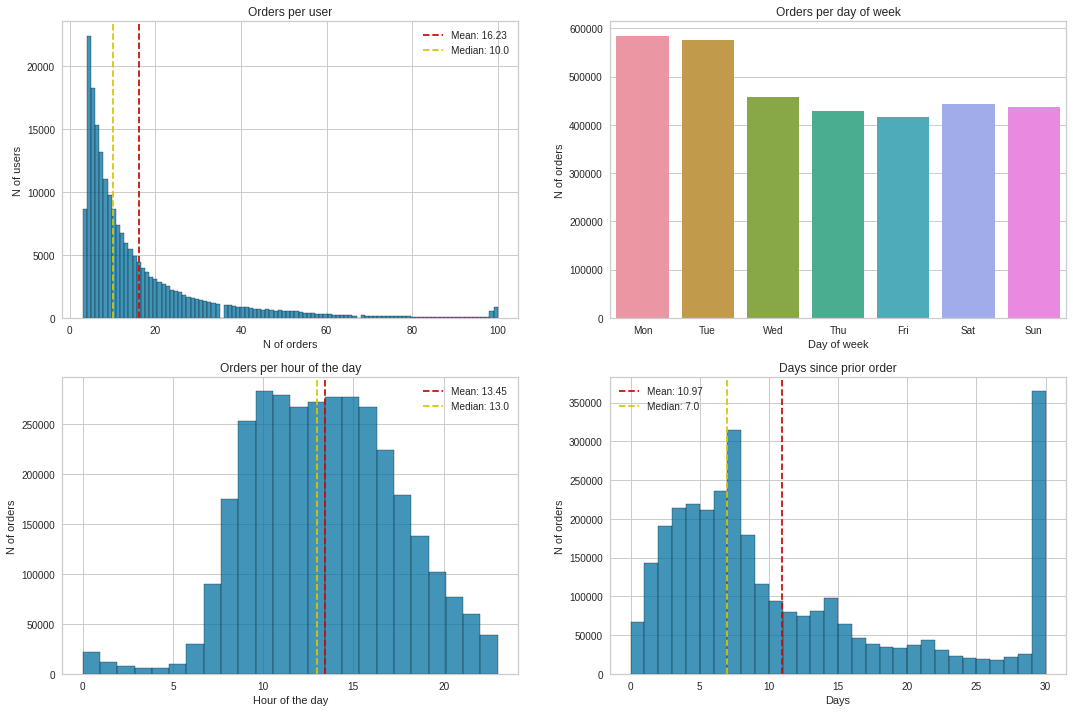

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))

# Ordenes por usuario
sns.histplot(orders_subset.user_id.value_counts(), bins = 100, ax = ax[0,0])
media = np.mean(orders_subset.user_id.value_counts())
mediana = np.median(orders_subset.user_id.value_counts())
ax[0,0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[0,0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[0,0].set_xlabel('N of orders')
ax[0,0].set_ylabel('N of users')
ax[0,0].set_title('Orders per user')
ax[0,0].legend()

# Ordenes por dia de la semana
sns.countplot(orders_subset.order_dow_name, order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ax = ax[0,1])
ax[0,1].set_xlabel('Day of week')
ax[0,1].set_ylabel('N of orders')
ax[0,1].set_title('Orders per day of week')

# Ordenes por hora del dia
sns.histplot(orders_subset.order_hour_of_day, bins = 24, ax = ax[1,0])
media = np.mean(orders_subset.order_hour_of_day)
mediana = np.median(orders_subset.order_hour_of_day)
ax[1,0].set_xlabel('Hour of the day')
ax[1,0].set_ylabel('N of orders')
ax[1,0].set_title('Orders per hour of the day')
ax[1,0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[1,0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[1,0].legend()


# Dias desde la ultima orden
sns.histplot(orders_subset.days_since_prior_order, bins = 30, ax = ax[1,1])
media = np.mean(orders_subset.days_since_prior_order)
mediana = orders_subset.days_since_prior_order.median()
ax[1,1].set_xlabel('Days')
ax[1,1].set_ylabel('N of orders')
ax[1,1].set_title('Days since prior order')
ax[1,1].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[1,1].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[1,1].legend()

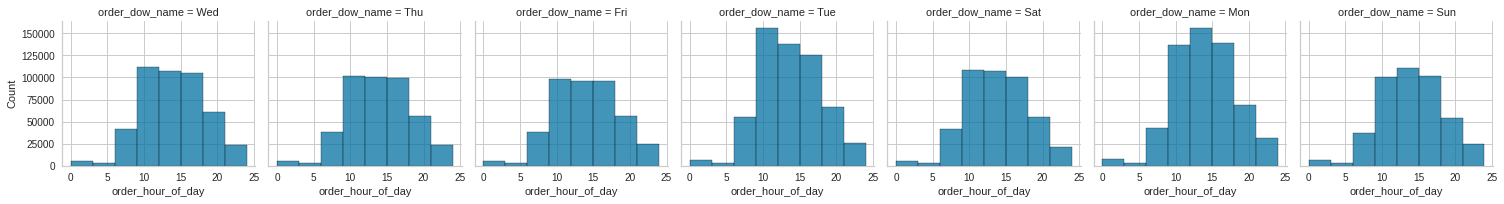

In [13]:
# Cantidad de ordenes por hora del dia, para cada dia de la semana
sns.displot(
    orders_subset, x = "order_hour_of_day", col = "order_dow_name",
    binwidth=3, height=3, facet_kws=dict(margin_titles=False),bins = 25
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


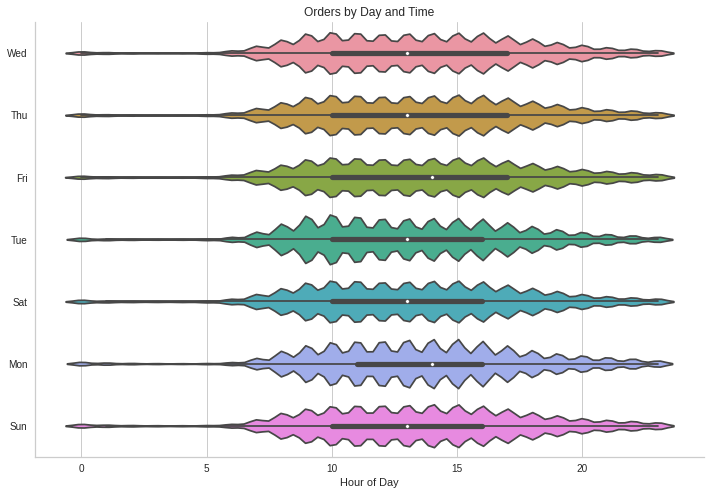

In [14]:
plt.figure(figsize=(12, 8))
sns.violinplot(orders_subset.order_hour_of_day, orders_subset.order_dow_name, orient='h')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.title('Orders by Day and Time')
sns.despine()

### Order Products

In [15]:
# Join both prior and train order_products

order_products = pd.concat([order_products_prior, order_products_train]).reset_index(drop = True)

Text(0.5, 1.0, 'Percentage of reorder')

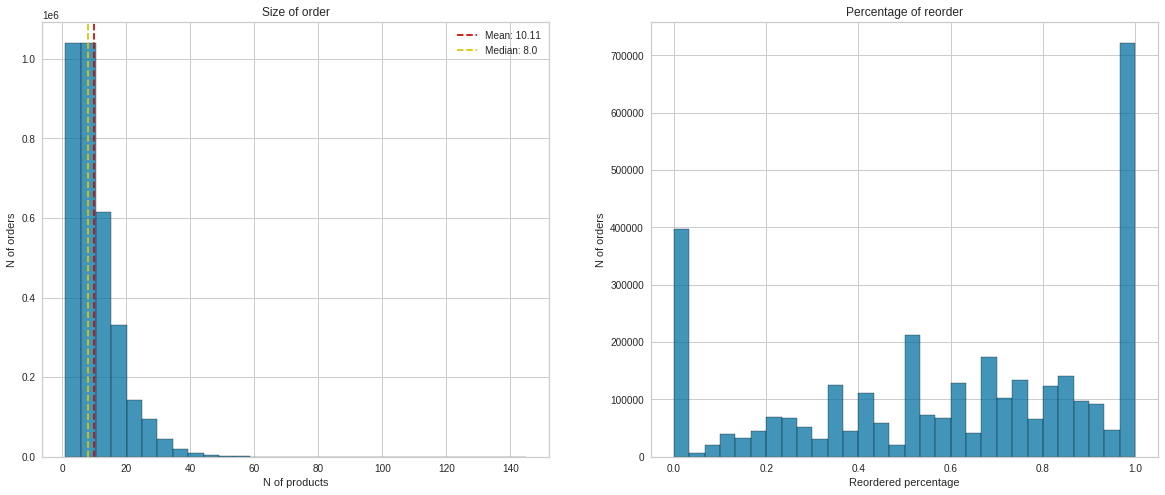

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

# Numero de productos por orden
media = np.mean(order_products.order_id.value_counts())
mediana = np.median(order_products.order_id.value_counts())
sns.histplot(order_products.order_id.value_counts(), bins = 30, ax = ax[0])
ax[0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[0].set_xlabel('N of products')
ax[0].set_ylabel('N of orders')
ax[0].set_title('Size of order')
ax[0].legend()

# Tasa de productos reordenados por orden

sns.histplot(order_products.groupby('order_id')['reordered'].mean(), bins = 30, ax = ax[1])
ax[1].set_xlabel('Reordered percentage')
ax[1].set_ylabel('N of orders')
ax[1].set_title('Percentage of reorder')

In [44]:
# Describe sobre el numero de productos por ordenes
tbl_1 = order_products.groupby('order_id').agg({'product_id':'count'}).describe()
tbl_1.rename(columns = {'product_id':'n_products_in_order'}, inplace = True)

# Describe sobre el porcentaje de re ordenacion
tbl_2 = order_products.groupby('order_id').agg({'reordered':'mean'}).describe()
tbl_2.rename(columns = {'reordered':'per_reordered'}, inplace = True)

# Join ambos 
tbl_1.join(tbl_2)

,n_products_in_order,per_reordered
count,3.346083e+06,3.346083e+06
mean,1.010707e+01,5.988126e-01
std,7.542326e+00,3.367931e-01
min,1.000000e+00,0.000000e+00
25%,5.000000e+00,3.333333e-01
50%,8.000000e+00,6.666667e-01
75%,1.400000e+01,9.032258e-01
max,1.450000e+02,1.000000e+00


#### Entendiendo en detalle la composicion de las órdenes

##### Órdenes con porcentaje de re ordenamiento del 100% y menor al 100%

In [48]:
# Detalle de la cantidad de productos en las ordenes con una tasa de re ordenación del 100%
order_products_grouped_reorder = order_products.groupby('order_id').agg({'reordered':'mean','product_id':'count'})
order_products_grouped_reorder.rename(columns = {'product_id':'q_products'}, inplace = True)

# Obtengo los quantiles para entender distribucion de la cantidad de productos 
# en las ordenes con 100% de productos re ordenados
tbl_1 = pd.DataFrame(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['q_products'].describe())


# Obtengo los quantiles para entender distribucion de la cantidad de productos 
# en las ordenes con menos de 100% de productos re ordenados
tbl_2 = pd.DataFrame(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['q_products'].describe())

# Joineo
tbl_1.join(tbl_2, lsuffix = '_full_reordered', rsuffix = '_no_full_reordered')

,q_products_full_reordered,q_products_no_full_reordered
count,719207.000000,2.626876e+06
mean,5.749913,1.130001e+01
std,5.044118,7.672981e+00
min,1.000000,1.000000e+00
25%,2.000000,6.000000e+00
50%,4.000000,1.000000e+01
75%,8.000000,1.500000e+01
max,102.000000,1.450000e+02


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of products - Not Full Reordered')

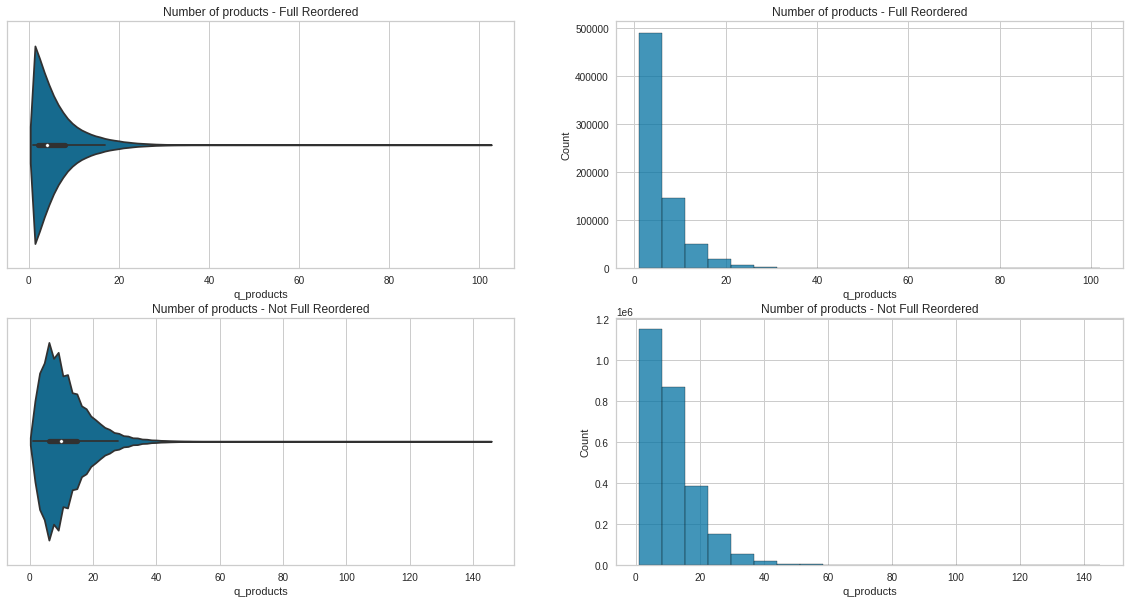

In [51]:
# Visualizo 
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10))
# 100% reorder
sns.violinplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['q_products'], ax = ax[0, 0])
sns.histplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['q_products'], bins = 20, ax = ax[0, 1])
ax[0,0].set_title('Number of products - Full Reordered')
ax[0,1].set_title('Number of products - Full Reordered')

# Menos de 100% reorder
sns.violinplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['q_products'], ax = ax[1, 0])
sns.histplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['q_products'], bins = 20, ax = ax[1, 1])
ax[1,0].set_title('Number of products - Not Full Reordered')
ax[1,1].set_title('Number of products - Not Full Reordered')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


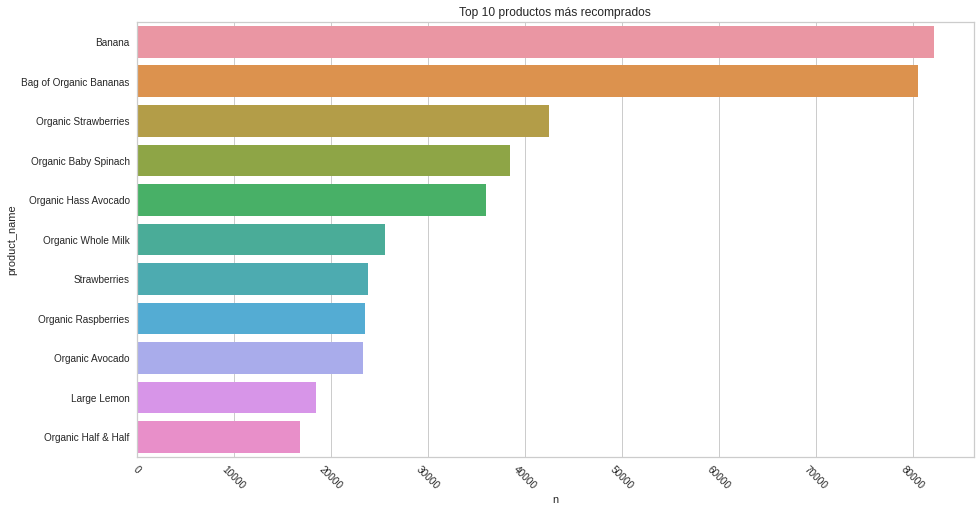

In [42]:
# Productos que suelen ser más recomprados 
# Primero mergeo las order products con las descripciones de cada producto
top_products_reorder = pd.merge(order_products, products[['product_id','product_name']], how = 'left', on = 'product_id')

# Obtengo la lista de ordenes con todos sus productos re ordenados 
full_reordered_orders = order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0].index.tolist()

# A partir de la lista anterior, filtro las órdenes que me interesan y agrupo 
# por product name para obtener la cantidad veces que se compraron dichos 
# productos y entender cuales son los productos más comunes
top_products_reorder = top_products_reorder[top_products_reorder['order_id'].isin(full_reordered_orders)].groupby('product_name', as_index = False).agg({'product_id':'count'})
top_products_reorder.rename(columns = {'product_id':'n'}, inplace = True)
top_products_reorder.sort_values(by = 'n', ascending = False, inplace = True)

# Plot
plt.figure(figsize = (15,8))
plt.xticks(rotation = -45)
plt.title('Top 10 productos más recomprados')
names = top_products_reorder['product_name'][:11]
orders = top_products_reorder['n'][:11]
sns.barplot(orders, names)

##### Entendiendo el volumen de compra por día

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


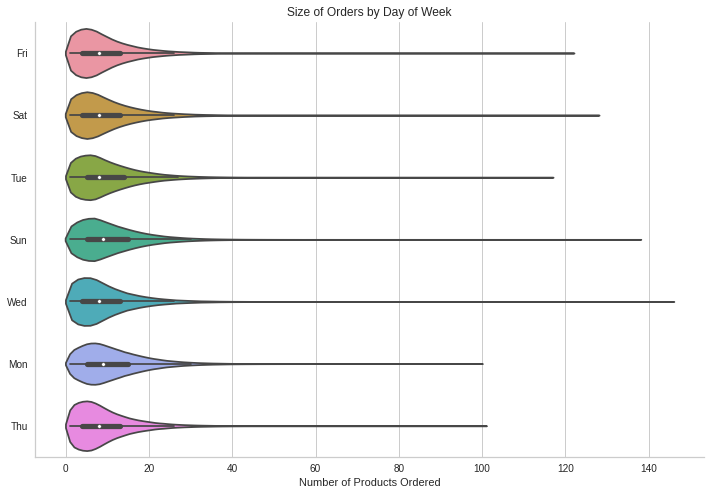

In [53]:
# Obtengo el tamaño de las ordenes segun el dia de la semana
order_products_temp = pd.merge(order_products, orders_subset[['order_id','order_dow_name']], how = 'left', on = 'order_id')
order_products_temp = order_products_temp.groupby(['order_id','order_dow_name'], as_index = False).agg({'product_id':'count'})

# Plot
plt.figure(figsize=(12, 8))
sns.violinplot(order_products_temp.product_id, order_products_temp.order_dow_name, 
               orient='h')
plt.xlabel('Number of Products Ordered')
plt.ylabel('')
plt.title('Size of Orders by Day of Week')
sns.despine()

##### Productos más comprados 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


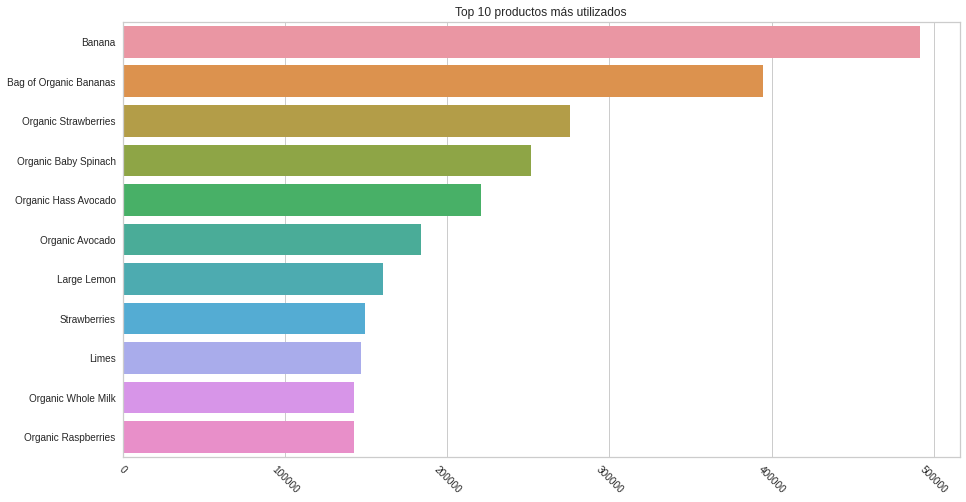

In [54]:
# Uno con la tabla de descripcion de productos
order_products = pd.merge(order_products, products[['product_id','product_name']], how = 'left', on = 'product_id')

# 10 Productos más comunes
plt.figure(figsize = (15,8))
plt.xticks(rotation = -45)
plt.title('Top 10 productos más utilizados')
names = order_products.product_name.value_counts()[:11].index
orders = order_products.product_name.value_counts()[:11].values
sns.barplot(orders, names)

### Products

Text(0.5, 1.0, 'Products in departments')

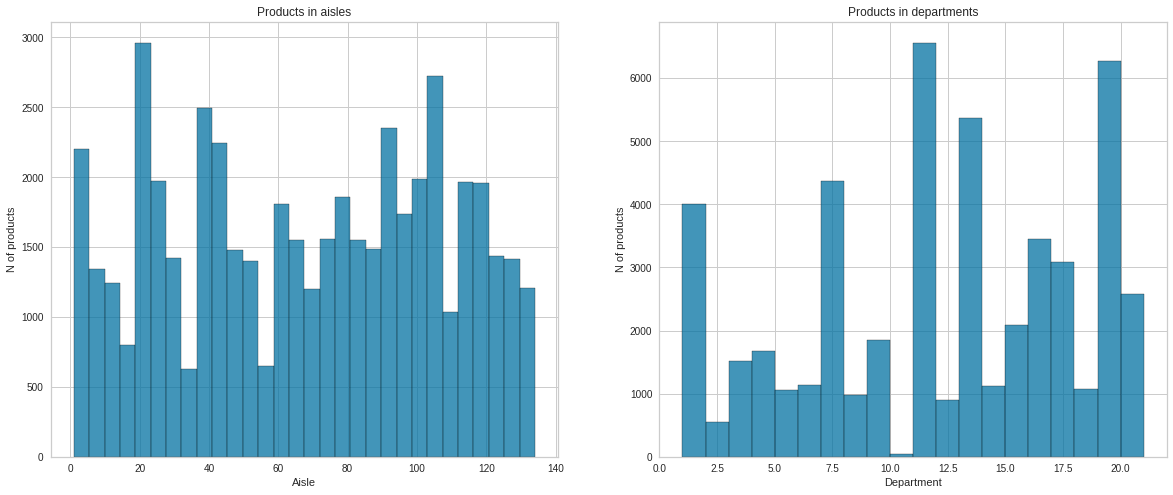

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

# Numero de productos por aisle

sns.histplot(products.aisle_id, bins = 30, ax = ax[0])
ax[0].set_xlabel('Aisle')
ax[0].set_ylabel('N of products')
ax[0].set_title('Products in aisles')


# Tasa de productos reordenados por orden

sns.histplot(products.department_id, bins = 20, ax = ax[1])
ax[1].set_xlabel('Department')
ax[1].set_ylabel('N of products')
ax[1].set_title('Products in departments')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


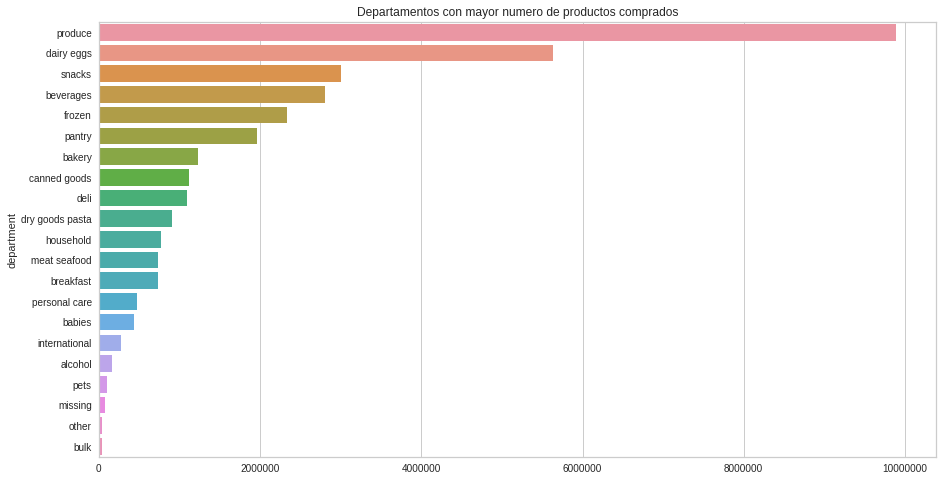

In [56]:
# Obtengo cantidad de productos por departamentos
# Mergeo los dataframes para conseguir las descripciones de los productos, asiles y departamentos
products_merged = pd.merge(products, order_products.drop(columns = ['product_name', 'add_to_cart_order'], axis = 1), on = 'product_id', how = 'left')
products_merged = pd.merge(products_merged, departments, on = 'department_id', how = 'left')
products_merged = pd.merge(products_merged, aisles, on = 'aisle_id', how = 'left')

# Calculo la cantidad total de productos por departamentos 
products_by_dep = products_merged.groupby(['department','product_name'], as_index = False).agg({'product_id':'count'})
products_by_dep = products_by_dep.groupby('department').agg({'product_id':'sum'})

# Plot
plt.figure(figsize = (15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Departamentos con mayor numero de productos comprados')
department = products_by_dep.sort_values(by = 'product_id', ascending = False).index
n_products = products_by_dep.sort_values(by = 'product_id', ascending = False)['product_id'].tolist()
sns.barplot(n_products, department)

## Customer Segmentation

### Feature Engineering

In [57]:
# Numero de productos por order id
prod_counts = order_products.groupby('order_id', as_index = False).agg({'product_id':'count'})
prod_counts.rename(columns = {'product_id':'num_products'}, inplace = True)

In [58]:
# Creo user data con información de cantidad de productos por orden
user_data = pd.merge(orders_subset, prod_counts, on = 'order_id', how = 'inner')

In [59]:
# Numero total de ordenes por usuario
num_orders = user_data.groupby('user_id', as_index = False).agg({'order_number':'max'})

In [60]:
# Flag para identificar si compra en dia pico (entre dia de la semana 0 o 1)
user_data['order_on_peak'] = np.where(user_data['order_dow'] <=1, 1, 0)

In [61]:
# Calculo el ratio al cual cada usuario ordena en días pico
peak_day_rate = round(user_data.groupby('user_id', as_index = False).agg({'order_on_peak':'mean'}), 3)

In [62]:
# Calculo la mediana para la hora del dia en que cada usuario realiza un pedido
median_hour = round(user_data.groupby('user_id', as_index = False).agg({'order_hour_of_day':'median'}), 3)

In [63]:
# Calculo ratio al cual los usuarios realizan pedidos durante horas picos 
# (10 y 16)

# Creo flag para detectar si el usuario realizó una compra durante hora pico
user_data['peak_time'] = np.where((user_data.order_hour_of_day >= 10) & 
                                  (user_data.order_hour_of_day <= 16), 1, 0)

# Calculo el ratio
peak_time_rate = round(user_data.groupby('user_id', as_index = False).agg({'peak_time':'mean'}), 3)

In [64]:
# Calculo la demora promedio entre pedidos por usuario
mean_lag = round(user_data.groupby('user_id', as_index = False).agg({'days_since_prior_order':'mean'}), 3)

In [65]:
# Calculo la cantidad de productos promedio comprados por usuario
mean_products = round(user_data.groupby('user_id', as_index = False).agg({'num_products':'mean'}), 0)

In [ ]:
# Agrupo todas las features
new_features = [num_orders, peak_day_rate, median_hour, peak_time_rate, mean_lag, mean_products]

# Seteo el user_id como indice para facilitar el join. De todas formas no es un
# dato relevante al momento de clusterizar
for feature in new_features:
  feature.set_index('user_id', inplace = True)

# Concateno
features = pd.concat(new_features, axis=1)
features.columns = ['num_orders', 'peak_day_rate', 'median_hour', 'peak_time_rate', 'mean_lag', 'mean_products']
features.head()

,num_orders,peak_day_rate,median_hour,peak_time_rate,mean_lag,mean_products
user_id,,,,,,
1,11,0.273,8.0,0.364,19.000,6.0
2,15,0.400,10.0,0.800,16.286,15.0
3,12,0.667,16.0,0.583,12.091,7.0
4,5,0.000,13.0,1.000,13.750,4.0
5,5,0.600,16.0,0.600,11.500,9.0


In [ ]:
  # Reviso valores faltantes
  features.isna().sum()

num_orders        0
peak_day_rate     0
median_hour       0
peak_time_rate    0
mean_lag          0
mean_products     0
dtype: int64

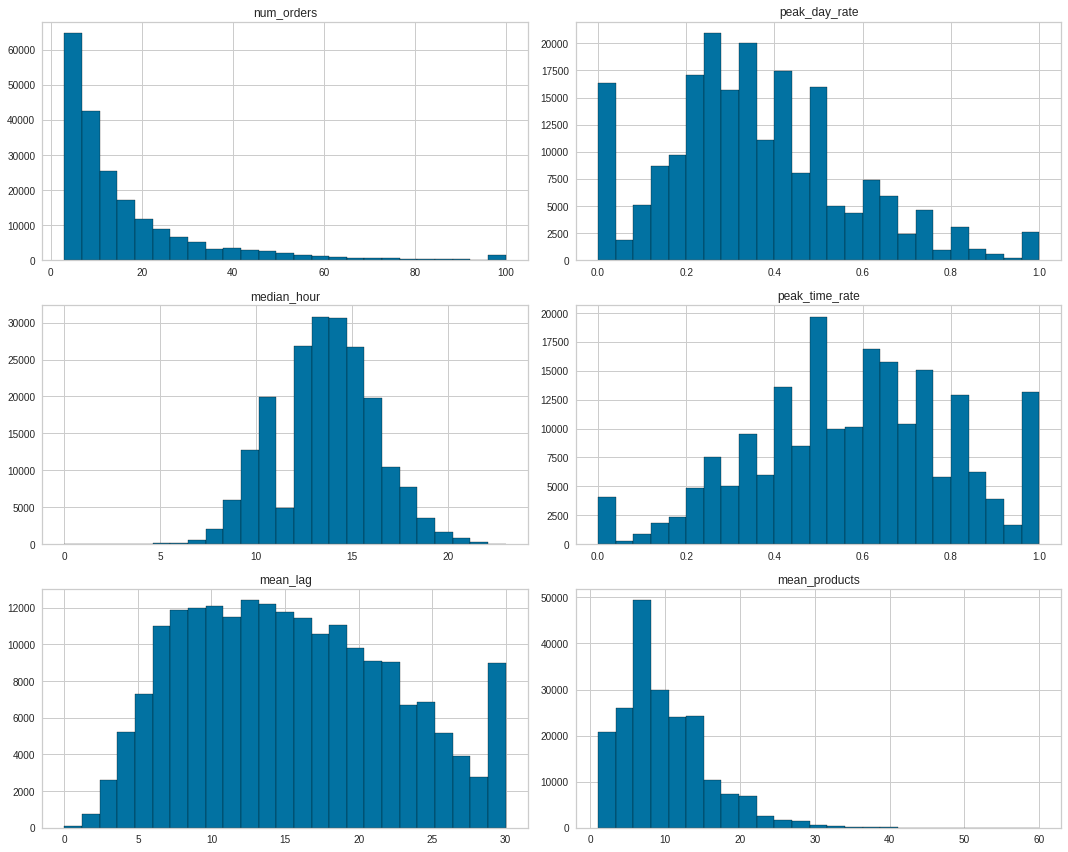

In [ ]:
# Visualizo la distribucion de estas variables para asegurar que tengan una 
# distribución "normal"

features.hist(figsize=(15,12), bins = 25, ec = 'black')
plt.tight_layout()

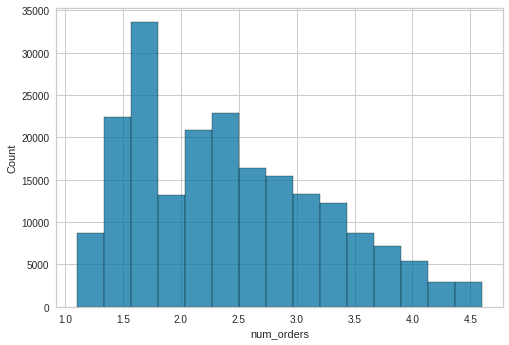

In [ ]:
# Realizo una log transform sobre el numero de ordenes
features['num_orders'] = np.log(features['num_orders'])
sns.histplot(features['num_orders'], bins = 15)

In [ ]:
# Selecciono al azar 25k usuarios para segmentar
random_users = random.sample(features.index.tolist(), 25000)
subset_features = features.filter(random_users, axis = 0)

# Escalo las features
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(subset_features)

# Convierto en dataframe 
feat_scaled = pd.DataFrame(feat_scaled)
feat_scaled.describe()

,0,1,2,3,4,5
count,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,-5.237366e-16,-1.298561e-16,-3.735856e-16,2.300560e-16,-2.766676e-17,1.396749e-16
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.575817e+00,-1.676517e+00,-5.264757e+00,-2.521486e+00,-2.205809e+00,-1.539320e+00
25%,-7.444942e-01,-6.650231e-01,-6.102521e-01,-6.577368e-01,-8.143106e-01,-6.844424e-01
50%,-1.318380e-01,-1.025570e-01,-2.843903e-02,8.515622e-02,-7.834492e-02,-1.715158e-01
75%,6.994847e-01,6.867863e-01,5.533741e-01,7.368168e-01,7.386287e-01,5.123863e-01
max,2.629756e+00,3.050089e+00,3.656377e+00,1.822918e+00,2.103124e+00,7.009456e+00


### Buscando el K óptimo

#### Con todas las features

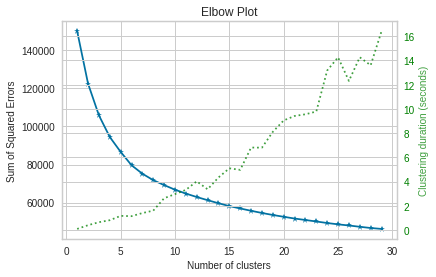

In [ ]:
import scikitplot as skplt

kmeans = KMeans(random_state=1)
skplt.cluster.plot_elbow_curve(kmeans, X = feat_scaled, cluster_ranges=range(1, 30), figsize = (10,8))

#### Con features tipo RFM

In [ ]:
# Select remaining features
features_dt = subset_features.drop(columns = ['median_hour', 'peak_day_rate', 'peak_time_rate'], axis = 1)

# Scale and convert to DataFrame
scaler = StandardScaler()
feat_dt_scaled = scaler.fit_transform(features_dt)
feat_dt_scaled = pd.DataFrame(feat_dt_scaled)

In [ ]:
features_dt.head()

,num_orders,mean_lag,mean_products
user_id,,,
7418,3.401197,11.966,4.0
137497,1.609438,8.000,14.0
49788,3.912023,6.020,9.0
199751,1.791759,26.400,1.0
102284,2.302585,23.111,18.0


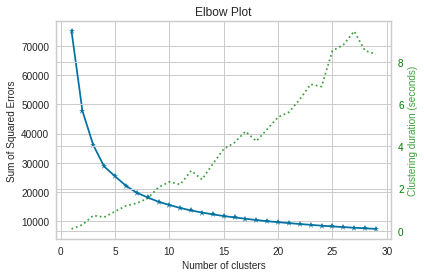

In [ ]:
kmeans = KMeans(random_state=1)
skplt.cluster.plot_elbow_curve(kmeans, X = feat_dt_scaled, cluster_ranges=range(1, 30))

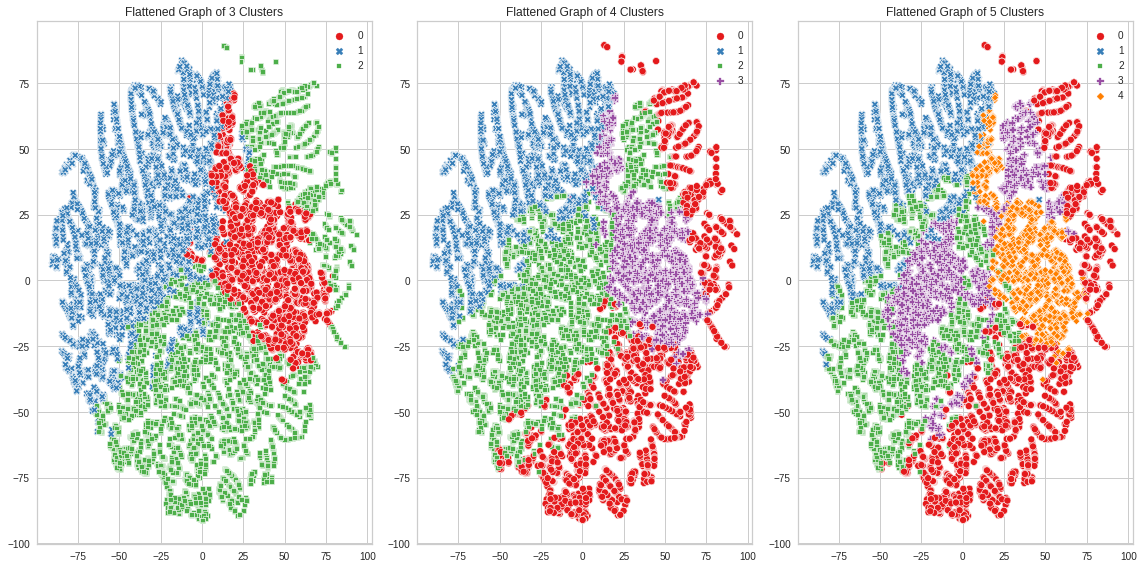

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3_small = kmeans_plot(feat_dt_scaled, 3)

plt.subplot(1, 3, 2)
k4_small = kmeans_plot(feat_dt_scaled, 4)

plt.subplot(1, 3, 3)
k5_small = kmeans_plot(feat_dt_scaled, 5)

plt.tight_layout()
plt.show()

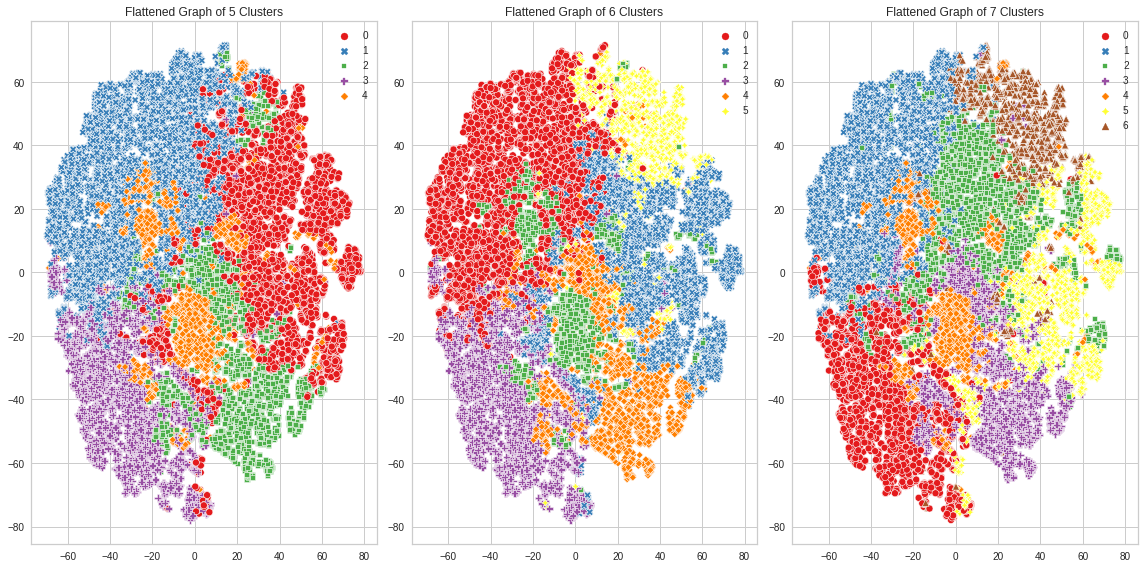

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k5 = kmeans_plot(feat_scaled, 5)

plt.subplot(1, 3, 2)
k6 = kmeans_plot(feat_scaled, 6)

plt.subplot(1, 3, 3)
k7 = kmeans_plot(feat_scaled, 7)

plt.tight_layout()
plt.show()

## Studying clusters

### Features RFM - 4 Clusters

In [ ]:
reduced_df_cluster = features_dt.copy()
reduced_df_cluster['cluster'] = k4_small[1]
reduced_df_cluster.head()

,num_orders,mean_lag,mean_products,cluster
user_id,,,,
7418,3.401197,11.966,4.0,1
137497,1.609438,8.000,14.0,2
49788,3.912023,6.020,9.0,1
199751,1.791759,26.400,1.0,0
102284,2.302585,23.111,18.0,3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Q de usuarios por cluster')

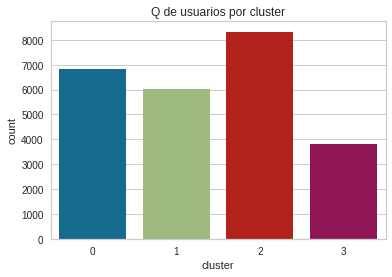

In [ ]:
sns.countplot(reduced_df_cluster.cluster)
plt.title('Q de usuarios por cluster')

In [ ]:
centroids_small = reduced_df_cluster.groupby('cluster', as_index = False).mean()

In [ ]:
centroids_small

,cluster,num_orders,mean_lag,mean_products
0,0,1.733725,23.603139,7.817292
1,1,3.554641,8.374321,9.739138
2,2,2.233195,13.052094,7.507626
3,3,2.223985,16.584566,19.778738


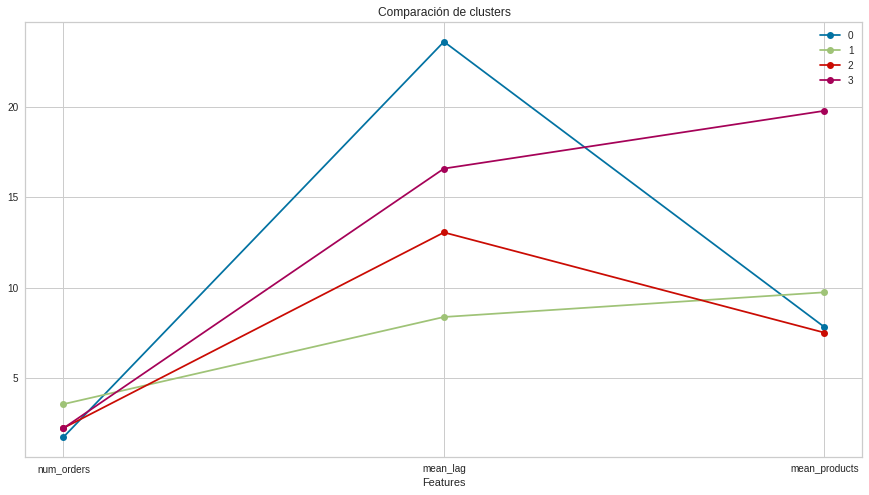

In [ ]:
plt.figure(figsize = (15,8))
for i in range(len(centroids_small)):
  plt.plot(centroids_small.columns[1:],centroids_small.iloc[i, 1:].values, '-o', label = centroids_small['cluster'][i])

plt.xlabel('Features')
plt.title('Comparación de clusters')
plt.legend()

### Features RFM - 3 Clusters

In [ ]:
reduced_df_cluster = features_dt.copy()
reduced_df_cluster['cluster'] = k3_small[1]
reduced_df_cluster.head()

,num_orders,mean_lag,mean_products,cluster
user_id,,,,
7418,3.401197,11.966,4.0,1
137497,1.609438,8.000,14.0,0
49788,3.912023,6.020,9.0,1
199751,1.791759,26.400,1.0,2
102284,2.302585,23.111,18.0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Q de usuarios por cluster')

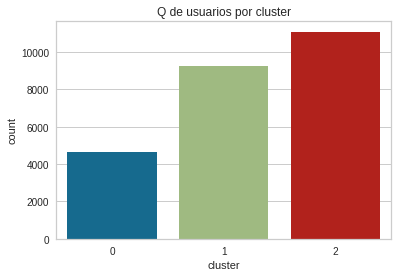

In [ ]:
sns.countplot(reduced_df_cluster.cluster)
plt.title('Q de usuarios por cluster')

In [ ]:
centroids_small = reduced_df_cluster.groupby('cluster', as_index = False).mean()
centroids_small

,cluster,num_orders,mean_lag,mean_products
0,0,2.180529,16.360280,18.836246
1,1,3.202879,9.354756,8.861842
2,2,1.848815,19.955764,7.266384


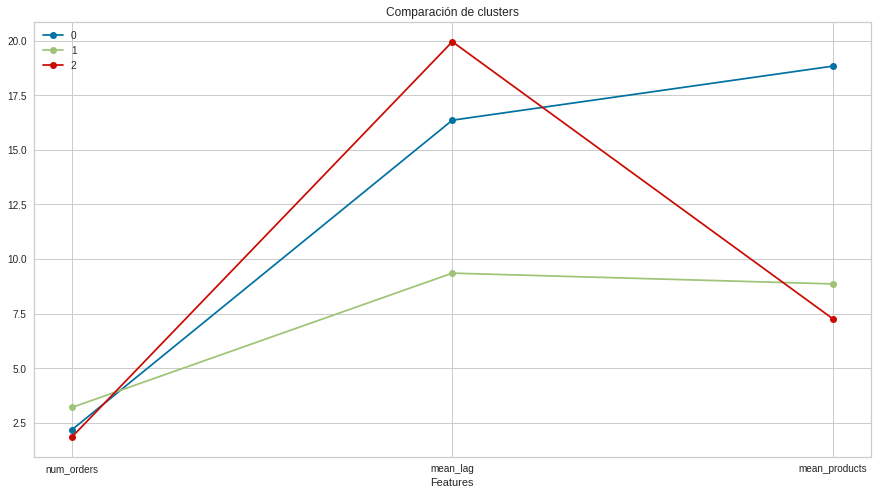

In [ ]:
plt.figure(figsize = (15,8))
for i in range(len(centroids_small)):
  plt.plot(centroids_small.columns[1:],centroids_small.iloc[i, 1:].values, '-o', label = centroids_small['cluster'][i])

plt.xlabel('Features')
plt.title('Comparación de clusters')
plt.legend()

### All features - 5 Clusters

In [ ]:
df_cluster = subset_features.copy()
df_cluster['cluster'] = k5[1]
df_cluster.head()

,num_orders,peak_day_rate,median_hour,peak_time_rate,mean_lag,mean_products,cluster
user_id,,,,,,,
7418,3.401197,0.233,12.5,0.6,11.966,4.0,1
137497,1.609438,0.600,16.0,0.6,8.000,14.0,2
49788,3.912023,0.360,15.0,0.6,6.020,9.0,1
199751,1.791759,0.500,13.0,1.0,26.400,1.0,2
102284,2.302585,0.200,14.0,0.9,23.111,18.0,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Q de usuarios por cluster')

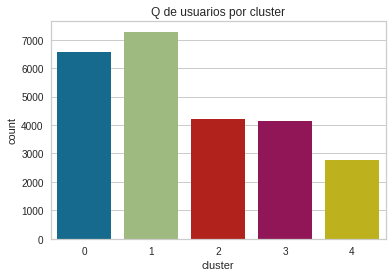

In [ ]:
sns.countplot(df_cluster.cluster)
plt.title('Q de usuarios por cluster')

In [ ]:
centroids = df_cluster.groupby('cluster', as_index = False).mean()

In [ ]:
centroids

,cluster,num_orders,peak_day_rate,median_hour,peak_time_rate,mean_lag,mean_products
0,0,1.901506,0.204209,12.436071,0.666107,19.146804,7.326882
1,1,3.360467,0.332716,13.013250,0.587036,8.876024,9.047920
2,2,1.948629,0.641380,13.081973,0.673104,18.720025,9.408091
3,3,2.072501,0.333527,17.106309,0.311027,17.094825,9.083795
4,4,2.348410,0.363244,13.193514,0.622228,15.685304,21.121081


Text(0.5, 1.0, 'Comparación de clusters (menos hora del día)')

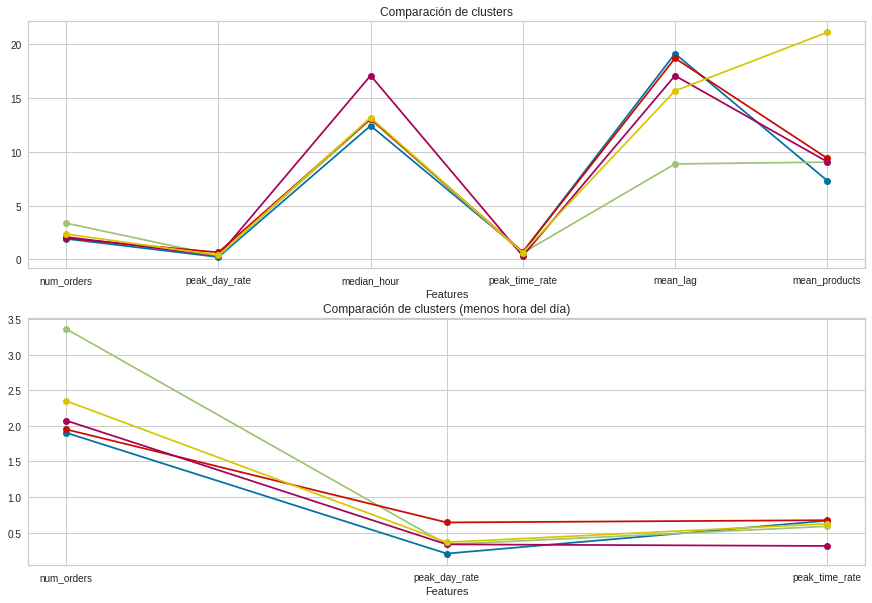

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (15, 10))
for i in range(len(centroids)):
  ax[0].plot(centroids.columns[1:],centroids.iloc[i, 1:].values, '-o')
  ax[1].plot(centroids.columns[[1,2,4]], centroids.iloc[i, [1,2,4]], '-o')

ax[0].set_xlabel('Features')
ax[0].set_title('Comparación de clusters')
ax[1].set_xlabel('Features')
ax[1].set_title('Comparación de clusters (menos hora del día)')
